In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV


In [ ]:
# I decided to do this with a package first to get an idea of what I am looking for since it is hard to develop without direction.
# Loading my dataset
df = pd.read_csv("IBMDataset.csv")

# Setting up the model
y = df['MonthlyIncome']
X = df.select_dtypes(include=[np.number]).drop(['MonthlyIncome', 'EmployeeNumber'], axis=1)
X = X.dropna(axis=1)

# Need to scale my data before I do feature selection:
# I did z-scaling from sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Setting up with packages

In [ ]:
# Stole and modified this from my exam 2 but using a package for the meantime instead of my custom linear reg.
# The idea of forward subset selection is basically to fit linear regressions with all of the features and keep the most impactful ones.
def forward_selection(X, y, max_features=None):
    # Keeping track of the currently selected/checked features to iterate through the remaining.
    remaining_features = list(X.columns)
    selected_features = []
    current_score, best_new_score = 0.0, 0.0
    max_features = max_features or len(remaining_features)

    # While there are featrues that have not been checked.
    while remaining_features and len(selected_features) < max_features:
        scores_with_candidates = []
        
        # This is fitting a linear regression for each of the models using the statsmodels package
        for candidate in remaining_features:
            formula = selected_features + [candidate]
            X_new = sm.add_constant(X[formula])
            model = sm.OLS(y, X_new).fit()
            score = model.rsquared_adj
            scores_with_candidates.append((score, candidate))

        # Here i check the best scores and rank the current features.
        scores_with_candidates.sort(reverse=True)
        best_new_score, best_candidate = scores_with_candidates[0]

        # Checking if there is a new best feature, removing the used feature.
        if best_new_score > current_score:
            remaining_features.remove(best_candidate)
            selected_features.append(best_candidate)
            current_score = best_new_score
            print(f"Added: {best_candidate} | Adjusted R²: {current_score:.4f}")
        else:
            break

    return selected_features


In [ ]:
# Fitting and printing my results
selected = forward_selection(X_scaled, y, max_features=10)
print("Final selected features:", selected)

Added: JobLevel | Adjusted R²: 0.9030
Added: TotalWorkingYears | Adjusted R²: 0.9052
Added: YearsWithCurrManager | Adjusted R²: 0.9059
Added: DistanceFromHome | Adjusted R²: 0.9063
Added: Age | Adjusted R²: 0.9065
Added: YearsSinceLastPromotion | Adjusted R²: 0.9066
Added: HourlyRate | Adjusted R²: 0.9066
Final selected features: ['JobLevel', 'TotalWorkingYears', 'YearsWithCurrManager', 'DistanceFromHome', 'Age', 'YearsSinceLastPromotion', 'HourlyRate']


In [ ]:
# Checking summary statistics (thankfully Statsmodel already does this)
X_selected = sm.add_constant(X_scaled[selected])
model = sm.OLS(y, X_selected).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          MonthlyIncome   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     2038.
Date:                Tue, 13 May 2025   Prob (F-statistic):               0.00
Time:                        18:13:59   Log-Likelihood:                -12771.
No. Observations:                1470   AIC:                         2.556e+04
Df Residuals:                    1462   BIC:                         2.560e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    6

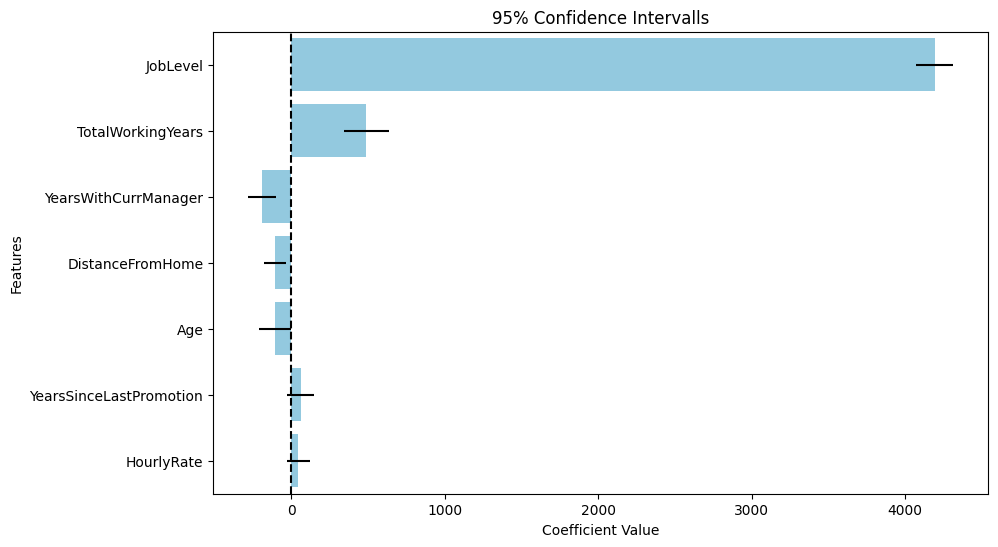

In [ ]:
# The purpose of this is to create a plot of confidence intervals, this is just an easy way to visualize the model.
coefs = model.params.drop("const")
conf = model.conf_int().drop("const")
errors = coefs - conf[0]

# Plotting with a bit of customization
plt.figure(figsize=(10, 6))
sns.barplot(x=coefs.values, y=coefs.index, orient='h', color='skyblue', xerr=errors.values)
plt.axvline(x=0, color='black', linestyle='--')
plt.title("95% Confidence Intervals")
plt.xlabel("Coefficient Value")
plt.ylabel("Features")
plt.show()
# Used official documentation for the little customization tidbits: https://matplotlib.org/stable/users/explain/quick_start.html

In [ ]:
# I also wanted to run a quick check with 
lasso = LassoCV(cv=5, random_state=7) # running lasso with 5 cross validations and seed of 7 (my fav number)
lasso.fit(X_scaled, y) # Re-using my scaled data

# Getting results.
selected_lasso_features = X.columns[lasso.coef_ != 0]
print("Selected Features with Lasso:", selected_lasso_features)
print("R-squared:", lasso.score(X_scaled, y))

# This is pretty much identical to forward subset so i don't think its valuable to re-do this from scratch.
# Used official documentation for the lasso: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html

Selected Features with Lasso: Index(['DistanceFromHome', 'HourlyRate', 'JobLevel', 'TotalWorkingYears',
       'YearsWithCurrManager'],
      dtype='object')
R-squared: 0.9062828031563842


# Setting up from scratch

<bound method NDFrame.head of       Age Attrition     BusinessTravel  DailyRate              Department  \
0      41       Yes      Travel_Rarely       1102                   Sales   
1      49        No  Travel_Frequently        279  Research & Development   
2      37       Yes      Travel_Rarely       1373  Research & Development   
3      33        No  Travel_Frequently       1392  Research & Development   
4      27        No      Travel_Rarely        591  Research & Development   
...   ...       ...                ...        ...                     ...   
1465   36        No  Travel_Frequently        884  Research & Development   
1466   39        No      Travel_Rarely        613  Research & Development   
1467   27        No      Travel_Rarely        155  Research & Development   
1468   49        No  Travel_Frequently       1023                   Sales   
1469   34        No      Travel_Rarely        628  Research & Development   

      DistanceFromHome  Education EducationFi